# Analyze adsorption isotherm anomalies

In [8]:
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import pprint
import os
import pygaps
import scipy

## Lets make a Python class for an adsorption isotherm

### This is usually referred to as class-based Object-Oriented Programming (OOP). 

#### [Here](https://pythonprogramming.net/introduction-learn-python-3-tutorials/)'s a tutorial series on Python if you want to learn the basics, and [Here](https://pythonprogramming.net/introduction-intermediate-python-tutorial/)'s an intermediate Python tutorial if the basic one is too easy.

#### More specifically, [This](https://pythonprogramming.net/object-oriented-programming-introduction-intermediate-python-tutorial/) is a tutorial on OOP in Python that I recommend, which introduces Classes

In [94]:
class Isotherm:
    # In Python classes, there is one required function you have to define, __init__ (for initialization)
    def __init__(self, filename):
        # This if-else sentence loads in the isotherm data. If you have extracted the isotherms into your directory, 
        #  you will load it directly, but if you haven't you'll have to download it from the NIST database.
        if os.path.isfile('isotherms/' + filename + '.json'):
            with open('isotherms/' + filename + '.json') as infile:
                isotherm_data = json.load(infile)
        else:
            url = "https://adsorption.nist.gov/isodb/api/isotherm/" + filename + ".json"
            isotherm_data = json.loads(requests.get(url).content)

        
        self.filename = filename
        self.doi = isotherm_data['DOI']
        assert len(isotherm_data['adsorbates']) < 2
        self.adsorbate = isotherm_data['adsorbates'][0]['name']
        self.inchikey = isotherm_data['adsorbates'][0]['InChIKey']
        self.adsorbent = isotherm_data['adsorbent']['name']
        self.category = isotherm_data['category']
        self.temperature = isotherm_data['temperature']
        self.adsorptionUnits = isotherm_data['adsorptionUnits']
        self.pressureUnits = isotherm_data['pressureUnits']
        self.pressure = np.array([isotherm_data['isotherm_data'][i]['pressure'] for i in range(len(isotherm_data['isotherm_data']))])
        self.adsorption = np.array([isotherm_data['isotherm_data'][i]['species_data'][0]['adsorption'] for i in range(len(isotherm_data['isotherm_data']))])
        self.henry_constant = None
        
    # Lets define a few helper functions first
    def _get_formula_from_inchikey(self):
        # Usually if there's an underscore in front of a function name, 
        #  it's meant for internal use
        url = "https://adsorbents.nist.gov/isodb/api/gas/" + self.inchikey + ".json"
        gas_data = json.loads(requests.get(url).content)
        self.formula = gas_data['formula']
    
    def get_molecular_weight(self):
        self._get_formula_from_inchikey()
        # We will need to read in the atomic masses to compute the molecular weight (mw):
        atomic_masses = pd.read_csv('data/atomicmasses.csv')
        
        # This splits the formula up into elements plus their frequency
        start_i = 0
        elements = []
        for end_i, letter in enumerate(self.formula[1:], start=1):
            if letter.isupper():
                elements.append([start_i, end_i])
                start_i = end_i
        elements.append([start_i, len(self.formula)])

        # This calculates the molecular weight of each type of element
        self.mw = 0
        for element in elements:
            form = self.formula[element[0]:element[1]]
            for i, letter in enumerate(form):
                if letter.isdigit():
                    element_mw = np.float(atomic_masses[atomic_masses.atom == form[:i]]['mass'])
                    self.mw = self.mw + element_mw * np.int(form[i:])
                    break
                if form.isalpha():
                    element_mw = np.float(atomic_masses[atomic_masses.atom == form]['mass'])
                    self.mw = self.mw + element_mw
                    break
        return self.mw
        
    def convert_units(self):
        # This will convert the pressure and adsorption to 'bar' and 'mmol/g', respectively, if needed
        # Pressure Units:
        assert self.pressureUnits == 'bar'

        # Adsorption Units:
        assert self.adsorptionUnits in ['cm3(STP)/g','g/g','mg/g','ml/g','mmol/g','mmol/kg','mol/g','wt%']

        aConversion = 0.0
        if self.adsorptionUnits == 'mmol/g':
            aConversion = 1.0
        elif self.adsorptionUnits == 'mmol/kg':
            aConversion = 1.0 / 1000.0
        elif self.adsorptionUnits == 'mol/g':
            aConversion = 1000.0
        elif self.adsorptionUnits in ['wt%', 'g/g']:
            mw = self.get_molecular_weight()
            aConversion = 1000.0 / mw
        elif self.adsorptionUnits in ['ml/g', 'cm3(STP)/g']:
            aConversion = 1.0 / 22.4
        elif self.adsorptionUnits == 'mg/g':
            mw = self.get_molecular_weight()
            aConversion = 1.0 / mw
        else:
            raise Exception('Something went horribly wrong!')

        self.adsorption = self.adsorption * aConversion
        self.adsorptionUnits = 'mmol/g'
        
    def fit_henry_constant(self, max_adjrms, verbose):
        # This will fit a Henry constant to the adsorption isotherm.
        # `max_adjrms` is a parameter used for the fitting procedure. 
        #  The default value is 0.01, but we can play around with this.
        # `verbose=True` will create a plot of the fit and give additional information
        # If the adsorption units are not in 'mmol/g' and the pressure units are not in 'bar',
        #  the assertion below will throw an error. Use `convert_units` to switch to the correct units
        assert self.adsorptionUnits == 'mmol/g' and self.pressureUnits == 'bar'
        isotherm = pygaps.PointIsotherm(
            pressure=self.pressure,
            loading=self.adsorption,
            material_name=self.adsorbent,
            material_batch='',
            t_iso=self.temperature,
            adsorbate=self.adsorbate)
        try:
            self.henry_constant = pygaps.initial_henry_slope(isotherm, max_adjrms, logx=False, verbose=verbose)
            return self.henry_constant
        except Exception as e:
            self.error = e
            print('Fitting procedure failed! See `self.error` as to why...')
            
    # Need to write this function
    def plot_isotherm(self):
        fig = plt.figure(figsize=(8,6))
        bad_datapoints = self.pressure[self.pressure < 0]
        good_datapoints = self.pressure[self.pressure >= 0]
        plt.scatter(self.pressure, self.adsorption, marker='o', label='Experimental')
        if self.henry_constant:
            plt.plot([0, self.pressure[-1]], [0, self.pressure[-1] * self.henry_constant], color='red', label="Henry's Law")
        plt.xlabel('Pressure [{}]'.format(self.pressureUnits))
        plt.ylabel('Adsorption [{}]'.format(self.adsorptionUnits))
        plt.ylim([-0.2*self.adsorption[-1], self.adsorption[-1] * 1.2])
        plt.legend()
        plt.show()
        

In [95]:
isotherm_df = pd.read_csv('data/list_of_high_isotherms.csv')
isotherm_df.head(10)

,Unnamed: 0,gas,material,henry_constant,filename,ok
0,961,UGFAIRIUMAVXCW-UHFFFAOYSA-N,NIST-MATDB-991daf7313251e7e607e2bab2da57e33,6.401857e+13,10.1016j.micromeso.2012.02.034.Isotherm2,True
1,1560,VNWKTOKETHGBQD-UHFFFAOYSA-N,NIST-MATDB-bbd809480ca8c8d0e4d066e70a9719d1,3.662595e+09,10.1016j.fluid.2014.08.020.Isotherm3,True
2,1190,VNWKTOKETHGBQD-UHFFFAOYSA-N,NIST-MATDB-2c9380bddc59f547484ff729eab7d7cb,2.593508e+09,10.1016j.fluid.2014.08.020.Isotherm2,True
3,1191,VNWKTOKETHGBQD-UHFFFAOYSA-N,NIST-MATDB-2c9380bddc59f547484ff729eab7d7cb,2.485209e+09,10.1016j.fluid.2014.08.020.Isotherm1,True
4,1847,HSFWRNGVRCDJHI-UHFFFAOYSA-N,NIST-MATDB-297c8ffe0f482757db45335130e02770,3.377586e+08,10.1007s11224-012-0120-1.isotherm35,True
5,1821,HSFWRNGVRCDJHI-UHFFFAOYSA-N,NIST-MATDB-1733c0f5ae26290495f099f06d0dd880,1.527369e+08,10.1007s11224-012-0120-1.isotherm36,True
6,1849,HSFWRNGVRCDJHI-UHFFFAOYSA-N,NIST-MATDB-297c8ffe0f482757db45335130e02770,9.760917e+06,10.1007s11224-012-0120-1.isotherm32,True
7,1822,HSFWRNGVRCDJHI-UHFFFAOYSA-N,NIST-MATDB-1733c0f5ae26290495f099f06d0dd880,9.610024e+06,10.1007s11224-012-0120-1.isotherm34,True
8,1848,HSFWRNGVRCDJHI-UHFFFAOYSA-N,NIST-MATDB-297c8ffe0f482757db45335130e02770,9.362430e+06,10.1007s11224-012-0120-1.isotherm33,True
9,1823,HSFWRNGVRCDJHI-UHFFFAOYSA-N,NIST-MATDB-1733c0f5ae26290495f099f06d0dd880,8.959582e+06,10.1007s11224-012-0120-1.isotherm31,True


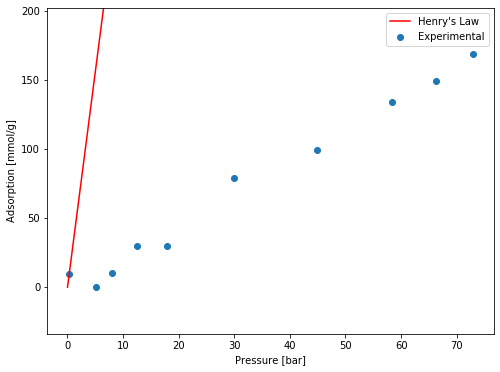

In [96]:
myiso = Isotherm('10.1002adfm.200500561.Isotherm4')
#print(myiso.adsorption)
myiso.convert_units()
#print(myiso.adsorption)
henry1 = myiso.fit_henry_constant(0.01, False)
#myiso.pressure[0] = -10.4
#henry2 = myiso.fit_henry_constant(0.01, True)
myiso.plot_isotherm()

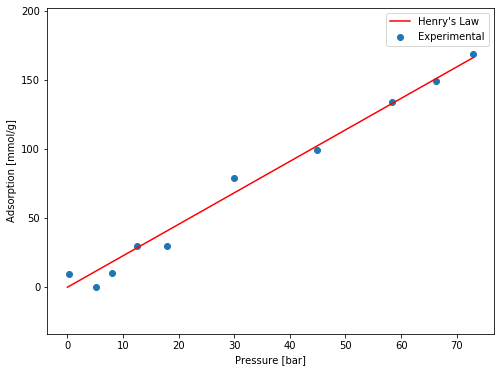

In [97]:
myiso = Isotherm('10.1002adfm.200500561.Isotherm4')
myiso.convert_units()
myiso.fit_henry_constant(20, False)
myiso.plot_isotherm()

In [89]:
myiso.adsorption

array([  9.68857273,   0.31041084,  10.14951287,  29.76184098,
        30.09107685,  79.17385956,  99.40671072, 134.06948826,
       149.05351509, 168.7977459 ])

In [21]:
import matplotlib.pyplot as plt
import numpy as np

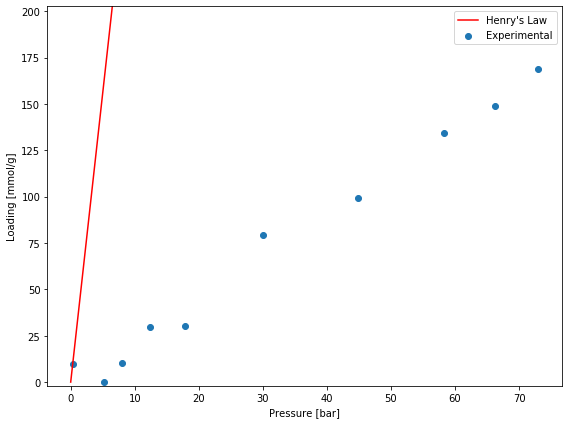

In [37]:
def plot_my_isotherm(pressure, adsorption, henry_coeff):
    fig = plt.figure(figsize = (8, 6))
    plt.scatter(pressure, adsorption, label='Experimental')
    plt.plot([0, pressure[-1]],[0, pressure[-1]*henry_coeff], color='red', label="Henry's Law")
    plt.ylim([-2, adsorption[-1]*1.2])
    plt.xlabel('Pressure [bar]')
    plt.ylabel('Loading [mmol/g]')
    plt.legend()
    plt.tight_layout()
    plt.show()
plot_my_isotherm(myiso.pressure, myiso.adsorption, 31.18545601368934)

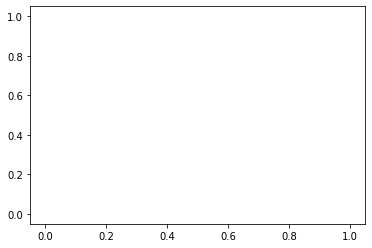

In [5]:
fig = plt.figure()
plt.plot([],[])
#plt.show()

In [28]:
myiso.adsorbate

'Hydrogen'

In [29]:
myiso.adsorbent

'IRMOF-1'

In [30]:
myiso.temperature

298